In [41]:
using LinearAlgebra;
using StaticArrays;
using Makie
using Makie:Point2f0
using CairoMakie
using Printf
using Symbolics


### Construction of the Hamiltonian ## 

In [117]:
# Here, we define the three vectors connecting nearest neighbor carbon atoms 
global const C_6::Matrix{Float64} = [cos(2.0*pi/3.0) -sin(2.0*pi/3.0); sin(2.0*pi/3.0) cos(2.0*pi/3.0)]
global const A1::Vector{Float64} = [1.0, 0.0]
global const A2::Vector{Float64} = C_6 * A1
global const A3::Vector{Float64} = C_6 * A2; 

# To define the Haldane term, we need B1, B2, and B3. They obey B1 + B2 + B3 = 0 
global const B1::Vector{Float64} = A2 - A1
global const B2::Vector{Float64} = A3 - A2 
global const B3::Vector{Float64} = A1 - A3; 

# Real and Reciprocal Lattice Vectors 
global const R::Matrix{Float64} = [B1 B2]'
global const G::Matrix{Float64} = 2.0 * pi * inv(R')

# Pauli Sigma Matrices 
global const sigma_x  = @SArray ComplexF64[0.0 1.0; 1.0 0.0]
global const sigma_y  = @SArray ComplexF64[0.0 -im; im 0.0]
global const sigma_z  = @SArray ComplexF64[1.0 0.0; 0.0 -1.0];


In [67]:
function plot_CC_bonds(A1::Vector{Float64}, A2::Vector{Float64}, A3::Vector{Float64})
    origin = Point2f0(0, 0)
    A1 = Point2f0(A1...)
    A2 = Point2f0(A2...)
    A3 = Point2f0(A3...)
    f = Figure()
    ax = Axis(f[1, 1], title = "Carbon-Carbon Bonds", aspect = 1)
    # Plot the B Arrows 
    B1_origin = A1
    B2_origin = A2 
    B3_origin = A3 
    arrows!(ax, [B1_origin, B2_origin, B3_origin], [B1, B2, B3], arrowsize = 0.2, linewidth = 4.0, color = :blue)
    # Plot the A Arrows
    arrows!(ax, [origin, origin, origin], [A1, A2, A3], arrowsize = 16.2, linewidth = 6.0, color = :red)

    ax.xlabel = L"k_x"
    ax.ylabel = L"k_y"
    f
end



plot_CC_bonds (generic function with 1 method)

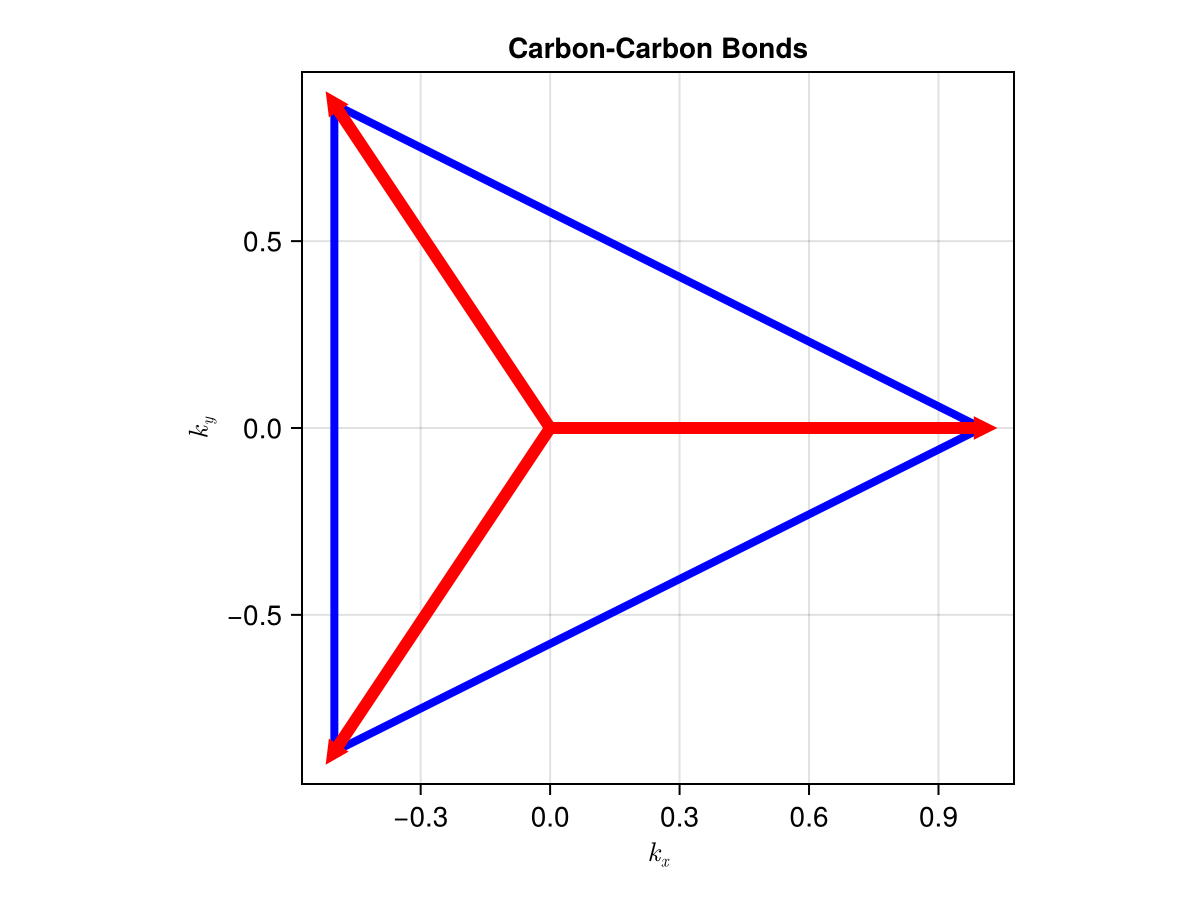

In [68]:
plot_CC_bonds(A1, A2, A3)

In [48]:
# Compute k1, k2, k3 using CAS provided in Symbolics 
@variables k1 k2 k3 kx ky
@variables k
k = [kx ky]
k1 = dot(k, A1)
k2 = dot(k, A2)
k3 = dot(k, A3);

println("k1 = ", k1)
println("k2 = ", k2)
println("k3 = ", k3)

k1 = kx
k2 = -0.4999999999999998kx + 0.8660254037844387ky
k3 = -0.5000000000000003kx - 0.8660254037844384ky


In [70]:
# Compute q1, q2, q3 using CAS provided in Symbolics 
@variables q1 q2 q3
@variables q
q = [kx ky]
q1 = dot(q, B1)
q2 = dot(q, B2)
q3 = dot(q, B3);

println("q1 = ", q1)
println("q2 = ", q2)
println("q3 = ", q3)

q1 = -1.4999999999999998kx + 0.8660254037844387ky
q2 = -5.551115123125783e-16kx - 1.7320508075688772ky
q3 = 1.5000000000000004kx + 0.8660254037844384ky


In [93]:
# Finally construct H 
@inline function H_Haldane(k::Vector{Float64}, M::Float64, t2::Float64)
    kx = k[1]; ky = k[2]
    gx = cos(kx) + cos(-0.5 * kx + 0.5 * sqrt(3.0) * ky) + cos(-0.5 * kx - 0.5 * sqrt(3.0) * ky)
    gy = -sin(kx) - sin(-0.5 * kx + 0.5 * sqrt(3.0) * ky) - sin(-0.5 * kx - 0.5 * sqrt(3.0) * ky)
    gz = M + 2.0 * t2 * (sin(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky) + sin(-sqrt(3.0) * ky) + sin(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky))
    gx * sigma_x + gy * sigma_y + gz * sigma_z 
end 

# evals 
@inline function evals(k::Vector{Float64}, M::Float64, t2::Float64)
    kx = k[1]; ky = k[2]
    gx = cos(kx) + cos(-0.5 * kx + 0.5 * sqrt(3.0) * ky) + cos(-0.5 * kx - 0.5 * sqrt(3.0) * ky)
    gy = -sin(kx) - sin(-0.5 * kx + 0.5 * sqrt(3.0) * ky) - sin(-0.5 * kx - 0.5 * sqrt(3.0) * ky)
    gz = M + 2.0 * t2 * (sin(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky) + sin(-sqrt(3.0) * ky) + sin(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky))
    eigvals(gx * sigma_x + gy * sigma_y + gz * sigma_z) 
end 

# eigensystem 
@inline function eigensystem_Haldane(k::Vector{Float64}, M::Float64, t2::Float64)
    kx = k[1]; ky = k[2]
    gx = cos(kx) + cos(-0.5 * kx + 0.5 * sqrt(3.0) * ky) + cos(-0.5 * kx - 0.5 * sqrt(3.0) * ky)
    gy = -sin(kx) - sin(-0.5 * kx + 0.5 * sqrt(3.0) * ky) - sin(-0.5 * kx - 0.5 * sqrt(3.0) * ky)
    gz = M + 2.0 * t2 * (sin(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky) + sin(-sqrt(3.0) * ky) + sin(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky))
    eigen(Hermitian(gx * sigma_x + gy * sigma_y + gz * sigma_z)) 
end 

eigensystem_Haldane (generic function with 1 method)

In [ ]:
# 3D Plots using CairoMakie backend 
function plot_bands3D_Haldane(;M::Float64, t2::Float64, seedname::String = "Haldane_", title::String = "Haldane Model")
    # construction of the grid 
    npts_perdim = 300
    rng = LinRange(-pi, pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end    


    E = evals.(grid, Ref(M), Ref(t2))
    ek_1 = map(x -> x[1], E)
    ek_2 = map(x -> x[2], E)
    
    kxs = reshape(map(e->e[1], grid), (npts_perdim, npts_perdim))
    kys = reshape(map(e->e[2], grid), (npts_perdim, npts_perdim))

    f = Figure()
    ax = Axis3(f[1, 1], title = title * " , M = $M, t2 = $t2", elevation = pi / 40.0)


    Makie.surface!(ax, kxs, kys,  ek_1, colormap = :viridis)
    Makie.surface!(ax, kxs, kys, ek_2, colormap = :viridis)
    ax.xlabel = L"k_x"
    ax.ylabel = L"k_y"
    #Makie.save(assets_dir * seedname * "M=$M" * "t2=$t2" * ".png", f)
    display(f)
end

plot_bands3D_Haldane (generic function with 1 method)

Matrix{SVector{2, Float64}}

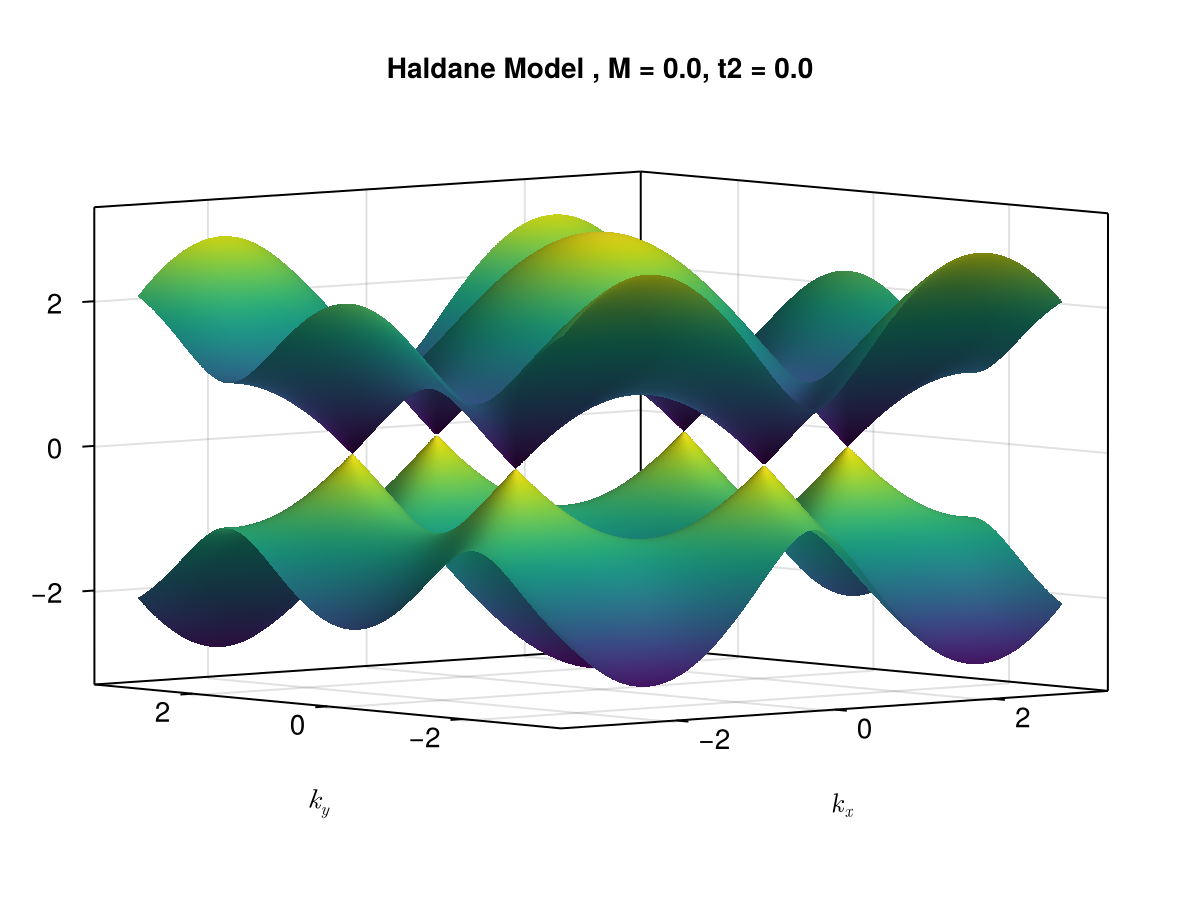

CairoMakie.Screen{IMAGE}


In [85]:
plot_bands3D_Haldane(M = 0.0, t2 = 0.0)

Matrix{SVector{2, Float64}}

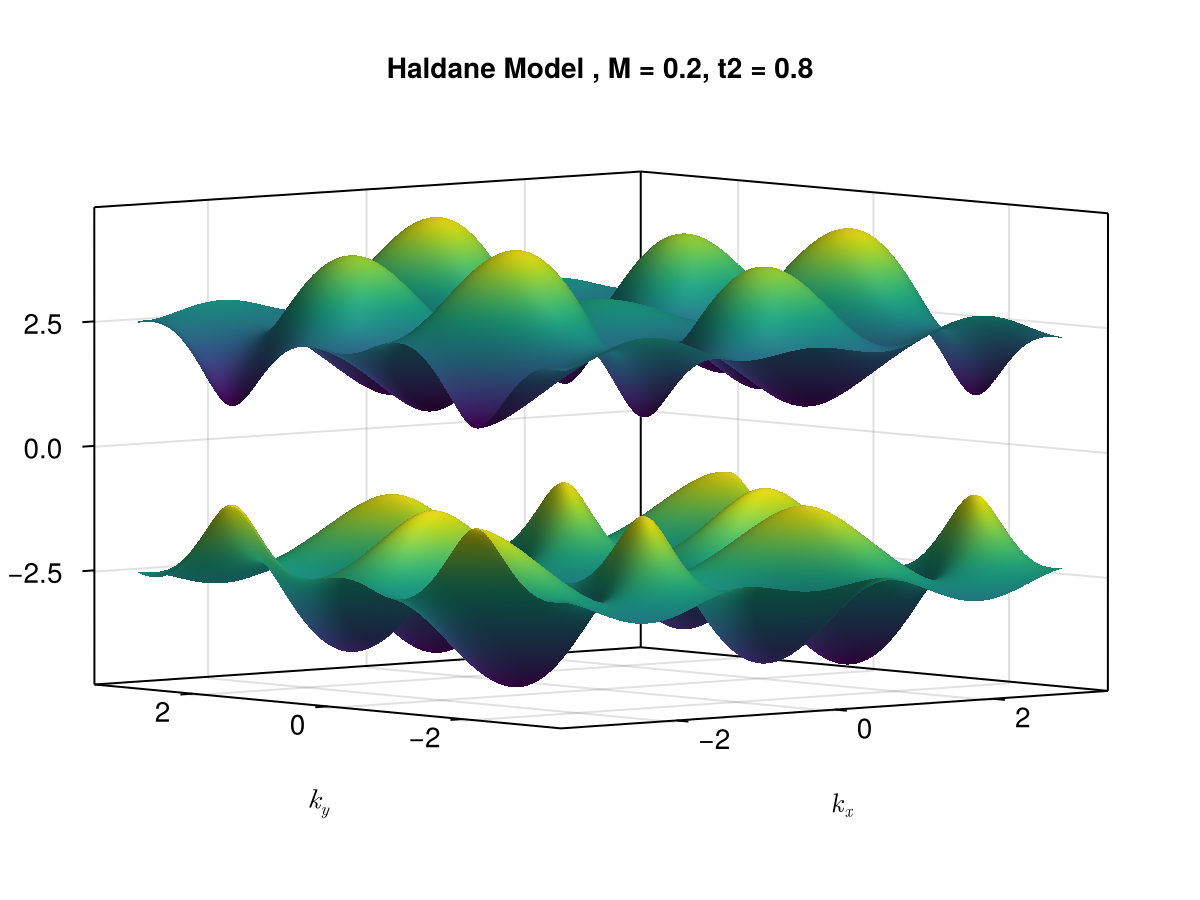

CairoMakie.Screen{IMAGE}


In [88]:
plot_bands3D_Haldane(M = 0.2, t2 = 0.8)

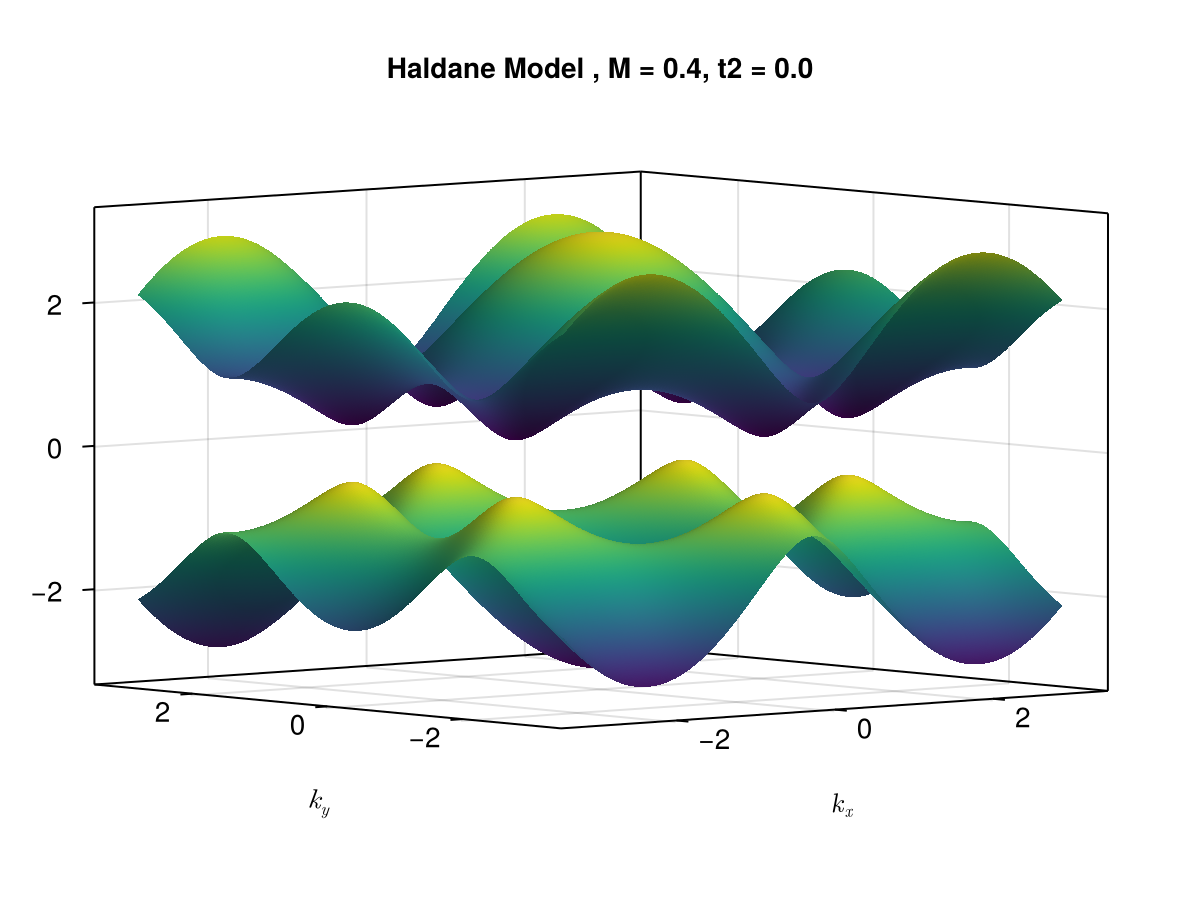

Matrix{SVector{2, Float64}}

CairoMakie.Screen{IMAGE}


In [121]:
plot_bands3D_Haldane(M = 0.4, t2 = 0.0)

In [133]:
function red_to_cart(recbasis, rvec)
    recbasis' * rvec
end
function get_line_fixed_k2(k2::Float64, nps::Int64, G::Matrix{Float64})
    lr::Vector{Vector{Float64}} = [[k1, k2] for k1 ∈ LinRange(0.0, 1.0, nps)]
    red_to_cart.(Ref(G), lr)
end
function get_line_fixed_k1(k1::Float64, nps::Int64, G::Matrix{Float64})
    lr::Vector{Vector{Float64}} = [[k1, k2] for k2 ∈ LinRange(0.0, 1.0, nps)]
    red_to_cart.(Ref(G), lr)
end

get_line_fixed_k1 (generic function with 1 method)

## Wilson Loop and Chern Number Calculations ##

In [136]:
@inline function Wilson_Loop_fixed_ycycle(ps_ky::Vector{Vector{Float64}}, M::Float64, t2::Float64, nps::Int = 1000)
    """
    This is similar to the Wilson loop computation in the SSH model, 
    I think it is possible to work out a connection between the two models (Dimensional reduction ?)
    """
    spectrum = eigensystem_Haldane.(ps_ky, Ref(M), Ref(t2))

    # get eigenmodes 
    U_grid     = map(x -> x.vectors, spectrum)
    U_band     = map(x -> x[:, 1], U_grid)
    # so far, we have the eigenmodes of the band at all points of the momentum space grid
    res::Complex{Float64} = 1.0 + 0.0 * im
    for n ∈ 1 : nps
        res *= U_band[n]' * U_band[mod1(n + 1, nps)]
    end
    angle(res)
end


@inline function Berry_Phase_Along_xcycle(M::Float64, t2::Float64, nps::Int = 1000, G::Matrix{Float64} = G)
    """
    Compute the Berry phase along the x cycle -- Goal is to calculate its monodromy
    """
    ps_k1 = LinRange(0.0, 1.0, nps)
    phase_vals = Vector{Float64}(undef, nps)
    for (n, k1) ∈ enumerate(ps_k1)
        kps = get_line_fixed_k1(k1, nps, G)
        phase_vals[n] = Wilson_Loop_fixed_ycycle(kps, M, t2, nps)
    end
    phase_vals
end

function unwrap(phis)
    """
    Note that we are interested in the phase of a complex number. There's a 2π ambiguity. 
    So, we are free to shift the result by 2π. 
    So, if chern number C = 1, the Φ phase shifts by Φ -> Φ + 1 as 
    we move from -π to π. If we use a gauge transformation such that Φ = 0 at -π, π, 
    we must have a singularity somewhere in the function. i.e. there is no smooth gauge transformations 
        that interpolate between different winding sectors 
    """
    phis_unwrapped = Float64[]
    push!(phis_unwrapped, phis[1])
    for i ∈ 2 : length(phis)
        Δ = phis[i] - phis[i - 1]
        if Δ > π
            Δ -= 2.0 * π
        elseif Δ < -π
            Δ += 2.0 * π 
        end
        push!(phis_unwrapped, phis_unwrapped[end] + Δ)
    end
    return phis_unwrapped
end

function Winding(fvals)
    fvals = unwrap(fvals)
    nvals = size(fvals, 1)
    res::Float64 = 0.0
    for n ∈ 1 : nvals - 1
        nnext = n + 1
        diff = fvals[nnext] - fvals[n]
        res += diff
    end
    res / 2π
end

Winding (generic function with 1 method)

# Phase Diagram for the Haldane Model , Fix M = 0.2 ---> 1 Dimensional Phase Diagram. 

In [153]:
function plot_chernnumber_on_parameterspace(M = 0.2, t2min = 0.0, t2max = 0.1, nps_wlcalc::Int = 100, G::Matrix{Float64} = G)
    # grid in parameter space;;; t2 value  
    ps = range(t2min, t2max, length = 100)
    # compute the topological index for each point in the parameter space
    Cs = Vector{Float64}(undef, 100)
    for (n, t2) ∈ enumerate(ps)
        Cs[n] = Winding(Berry_Phase_Along_xcycle(0.2, t2, nps_wlcalc, G))
    end
    f = Figure()
    ax = Axis(f[1, 1], title = "Chern number of the Haldane model , M = $M")
    ax.xlabel = L"t_2"
    ax.ylabel = "Chern Number"
    lines!(ax, ps, Cs, color = :blue, linewidth = 2)
    f
end


plot_chernnumber_on_parameterspace (generic function with 8 methods)

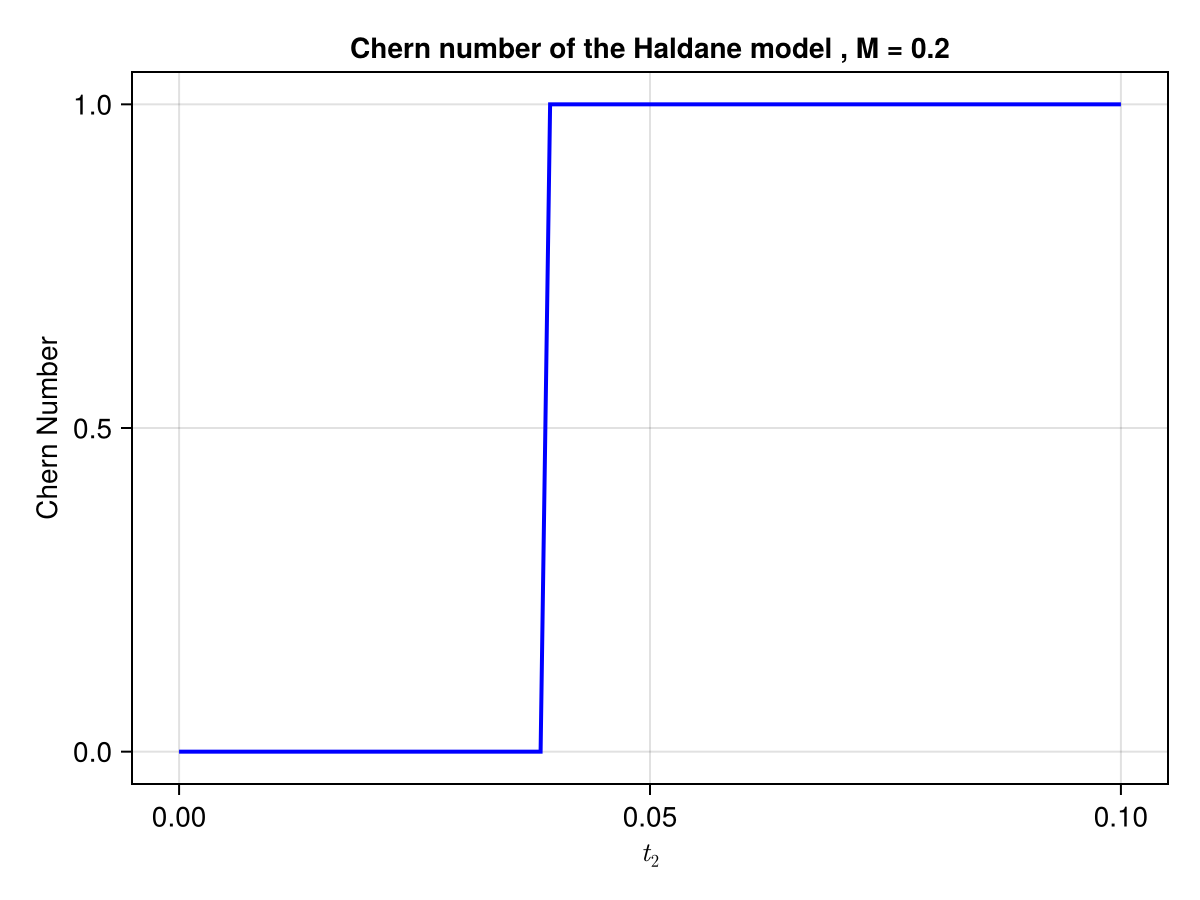

In [154]:
plot_chernnumber_on_parameterspace()